In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import shutil
from shutil import copyfile
from PIL import ImageOps
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import euclidean
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.applications import VGG16
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, MaxPooling2D 
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [3]:
# Creating mixed emotion folders
base_path = r"C:\Users\User\Desktop\images"
train_path = os.path.join(base_path, "train")
validation_path = os.path.join(base_path, "validation")
train_combo_path = os.path.join(base_path, "train_combo")
validation_combo_path = os.path.join(base_path, "validation_combo")

# Creating destination folders
os.makedirs(train_combo_path, exist_ok=True)
os.makedirs(validation_combo_path, exist_ok=True)

emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

for emotion in emotions:
  source_path = os.path.join(train_path, emotion)
  destination_path = os.path.join(train_combo_path, emotion)
  os.makedirs(destination_path, exist_ok=True)  # Create destination folder 

  # Copy all files from source to destination
  for filename in os.listdir(source_path):
    source = os.path.join(source_path, filename)
    destination = os.path.join(destination_path, filename)
    os.replace(source, destination)  

for emotion in emotions:
  source_path = os.path.join(validation_path, emotion)
  destination_path = os.path.join(validation_combo_path, emotion)
  os.makedirs(destination_path, exist_ok=True)

  # Copy all files from source to destination
  for filename in os.listdir(source_path):
    source = os.path.join(source_path, filename)
    destination = os.path.join(destination_path, filename)
    os.replace(source, destination)  

In [4]:
# Data preparation and Model training
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Defining training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_combo_path,
    target_size=(48, 48),  
    batch_size=32,
    class_mode='categorical'  
)

validation_generator = validation_datagen.flow_from_directory(
    validation_combo_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7059 images belonging to 7 classes.


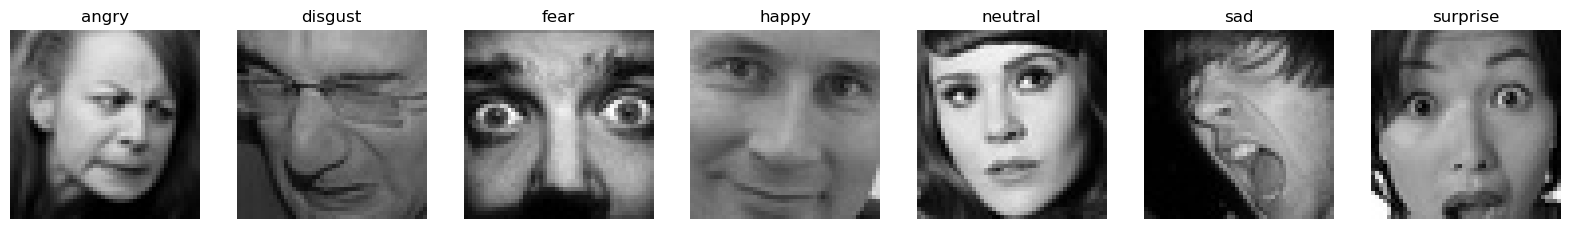

In [57]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(48, 48)):
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image)
    image_array /= 255.0  # Normalize the image
    return image_array

# Plot a sample image from each category
fig, axes = plt.subplots(1, len(categories), figsize=(20, 5))

for i, category in enumerate(categories):
    # Get the path of the first image in each category
    category_path = os.path.join(validation_combo_path, category)
    image_files = os.listdir(category_path)
    
    if not image_files:  # Skip if the category directory is empty
        print(f"No images found in category '{category}'")
        continue
    
    first_image_path = os.path.join(category_path, image_files[0])
    
    # Load and preprocess the image
    image = load_and_preprocess_image(first_image_path)
    
    # Plot the image
    axes[i].imshow(image)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.show()

In [5]:
# Define VGG16 model with transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False  # Experiment with freezing vs. fine-tuning

x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # 7 for your 7 emotions

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)  # Monitor validation accuracy

# Train the model with Early Stopping
model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])

loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

Epoch 1/10
901/901 [==============================] - 236s 261ms/step - loss: 1.6693 - accuracy: 0.3347 - val_loss: 1.5928 - val_accuracy: 0.3903
Epoch 2/10
901/901 [==============================] - 302s 335ms/step - loss: 1.6033 - accuracy: 0.3712 - val_loss: 1.5551 - val_accuracy: 0.3974
Epoch 3/10
901/901 [==============================] - 322s 358ms/step - loss: 1.5779 - accuracy: 0.3854 - val_loss: 1.5320 - val_accuracy: 0.4145
Epoch 4/10
901/901 [==============================] - 325s 361ms/step - loss: 1.5654 - accuracy: 0.3924 - val_loss: 1.5312 - val_accuracy: 0.4168
Epoch 5/10
901/901 [==============================] - 333s 369ms/step - loss: 1.5507 - accuracy: 0.3965 - val_loss: 1.5319 - val_accuracy: 0.4124
Epoch 6/10
901/901 [==============================] - 314s 349ms/step - loss: 1.5408 - accuracy: 0.4018 - val_loss: 1.5293 - val_accuracy: 0.4145
Epoch 7/10
116/901 [==>...........................] - ETA: 3:41 - loss: 1.5243 - accuracy: 0.4052

KeyboardInterrupt: 

Epoch 1/10
901/901 [==============================] - 218s 242ms/step - loss: 1.4785 - accuracy: 0.4266 - val_loss: 1.4930 - val_accuracy: 0.4314
Epoch 2/10
901/901 [==============================] - 297s 329ms/step - loss: 1.4721 - accuracy: 0.4321 - val_loss: 1.4892 - val_accuracy: 0.4348
Epoch 3/10
901/901 [==============================] - 297s 330ms/step - loss: 1.4707 - accuracy: 0.4318 - val_loss: 1.4957 - val_accuracy: 0.4270
Epoch 4/10
901/901 [==============================] - 297s 329ms/step - loss: 1.4666 - accuracy: 0.4350 - val_loss: 1.4911 - val_accuracy: 0.4294
Epoch 5/10
901/901 [==============================] - 318s 352ms/step - loss: 1.4595 - accuracy: 0.4358 - val_loss: 1.4990 - val_accuracy: 0.4265


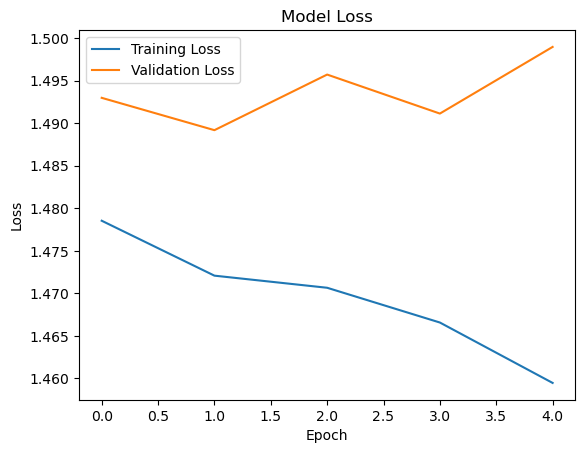

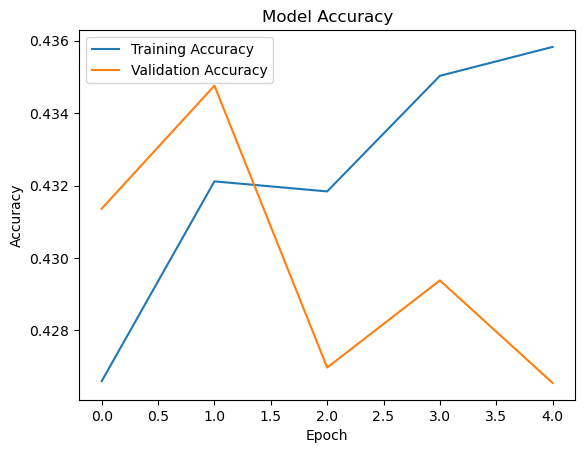

In [58]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])

# Extract training and validation loss/accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy (similar to loss plot)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def predict_emotion(preprocessed_image):
    # Use the trained model to predict
    predictions = model.predict(preprocessed_image)
    return predictions

def load_and_preprocess_image(image_path, target_size=(48, 48)):
    # Load the image
    image = load_img(image_path, target_size=target_size)
    # Convert the image to an array
    image_array = img_to_array(image)
    # Scale the pixel values to [0, 1]
    image_array = image_array / 255.0
    # Add batch dimension
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

image_paths = [
    r"C:\Users\User\Desktop\happy_face_bw.jpg",
    r"C:\Users\User\Desktop\happy_face-bw.jpg",
    r"C:\Users\User\Desktop\neutral_face_bw.jpg",
    r"C:\Users\User\Desktop\neutral_face-bw.jpg",
    r"C:\Users\User\Desktop\sad_face_bw.jpg",
    r"C:\Users\User\Desktop\sad_face-bw.jpg",
    r"C:\Users\User\Desktop\surprise_face_bw.jpg",
    r"C:\Users\User\Desktop\surprise_face-bw.jpg",
    r"C:\Users\User\Desktop\angry_face_bw.jpg",
    r"C:\Users\User\Desktop\angry_face-bw.jpg",
    r"C:\Users\User\Desktop\fear_face_bw.jpg",
    r"C:\Users\User\Desktop\fear_face-bw.jpg",
    r"C:\Users\User\Desktop\disgust_face_bw.jpg",
    r"C:\Users\User\Desktop\disgust_face-bw.jpg"
]

categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

for image_path in image_paths:
    # Load and preprocess the image
    preprocessed_image = load_and_preprocess_image(image_path)

    # Get model predictions
    predictions = predict_emotion(preprocessed_image)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(predictions[0])

    # Get the predicted emotion
    predicted_emotion = categories[predicted_class_index]

    # Print the prediction
    print(f"Predicted Emotion for {image_path}: {predicted_emotion}")

    # Display the image and prediction
    plt.figure()
    plt.imshow(load_img(image_path))
    plt.title(f"Predicted Emotion: {predicted_emotion}")
    plt.axis('off')  # Hide the axes
    plt.show()

221/221 [==============================] - 35s 157ms/step


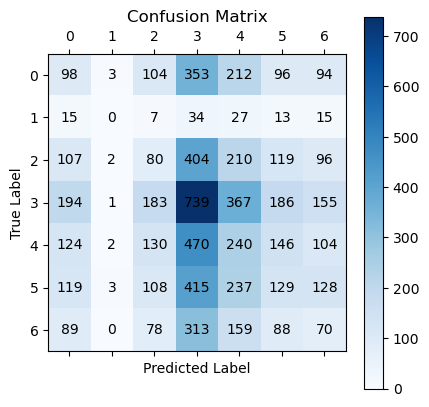

In [64]:
# Get predictions on validation data
y_pred_prob = model.predict(validation_generator, steps=len(validation_generator))
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert predicted probabilities to class labels
y_true = validation_generator.classes  # Assuming classes are available in the generator

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using matplotlib
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], va='center', ha='center')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [48]:
# Define the numerical feature vectors for each emotion category (replace with actual feature vectors)
features = {
    "angry": np.array([1, 2, 3]),
    "disgust": np.array([4, 5, 6]),
    "fear": np.array([7, 8, 9]),
    "happy": np.array([2, 3, 4]),
    "neutral": np.array([5, 6, 7]),
    "sad": np.array([8, 9, 10]),
    "surprise": np.array([3, 4, 5])
}

# Extract emotion names and feature vectors
emotion_names = list(features.keys())
feature_vectors = list(features.values())

# Calculate pairwise distances between feature vectors
distances = np.zeros((len(feature_vectors), len(feature_vectors)))
for i in range(len(feature_vectors)):
    for j in range(i + 1, len(feature_vectors)):
        distances[i, j] = euclidean(feature_vectors[i], feature_vectors[j])
        distances[j, i] = distances[i, j]  # Symmetric matrix

# Print the distance matrix
print("Pairwise Euclidean Distances between Emotion Categories:")
print(distances)

Pairwise Euclidean Distances between Emotion Categories:
[[ 0.          5.19615242 10.39230485  1.73205081  6.92820323 12.12435565
   3.46410162]
 [ 5.19615242  0.          5.19615242  3.46410162  1.73205081  6.92820323
   1.73205081]
 [10.39230485  5.19615242  0.          8.66025404  3.46410162  1.73205081
   6.92820323]
 [ 1.73205081  3.46410162  8.66025404  0.          5.19615242 10.39230485
   1.73205081]
 [ 6.92820323  1.73205081  3.46410162  5.19615242  0.          5.19615242
   3.46410162]
 [12.12435565  6.92820323  1.73205081 10.39230485  5.19615242  0.
   8.66025404]
 [ 3.46410162  1.73205081  6.92820323  1.73205081  3.46410162  8.66025404
   0.        ]]


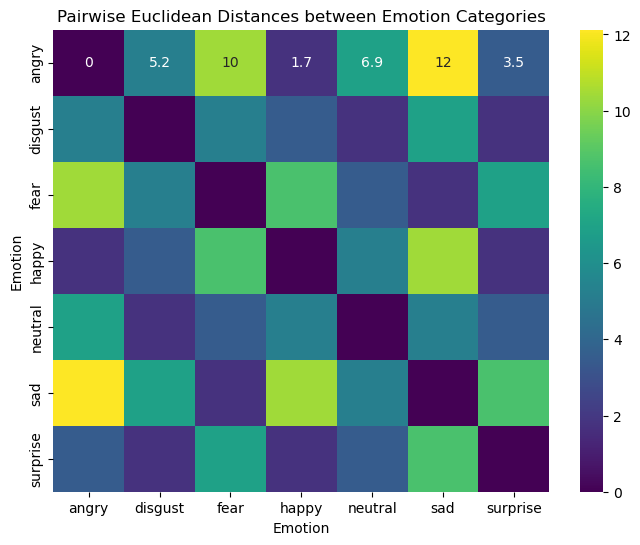

In [49]:
# Create a heatmap to visualize the distances
plt.figure(figsize=(8, 6))
sns.heatmap(distances, xticklabels=emotion_names, yticklabels=emotion_names, cmap='viridis', annot=True)
plt.title('Pairwise Euclidean Distances between Emotion Categories')
plt.xlabel('Emotion')
plt.ylabel('Emotion')
plt.show()